<a href="https://colab.research.google.com/github/nina-prog/DataAnalysis_VAE/blob/main/VAE_v2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Dropout, Reshape, BatchNormalization, LeakyReLU, Flatten
from keras.utils.vis_utils import plot_model
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
import pickle


sns.set()
sns.set_palette(sns.color_palette("Set1")) #tab10 #viridis
sns.set_style("whitegrid")
sns.set_context("paper")


# Data Preprocessing

---



## Load Data

In [18]:
### Load ecg5000 data using read_csv
ecg5000 = pd.read_csv('ECG5000_ALL.txt', sep='\s+', header=None)

In [19]:
### Optional test and info about data set
print("Type of ecg5000: \t \t {}".format(type(ecg5000)))
print("Dimensions of ecg5000: \t \t {}".format(ecg5000.shape))
print("Number of elements of ecg5000: \t {}".format((ecg5000.size)))
print("Display first 10 rows of ecg5000: \n {}".format(ecg5000.head(10)))

Type of ecg5000: 	 	 <class 'pandas.core.frame.DataFrame'>
Dimensions of ecg5000: 	 	 (5000, 141)
Number of elements of ecg5000: 	 705000
Display first 10 rows of ecg5000: 
    0         1         2         3    ...       137       138       139       140
0  1.0 -0.112522 -2.827204 -3.773897  ...  0.228077  0.123431  0.925286  0.193137
1  1.0 -1.100878 -3.996840 -4.285843  ...  0.476333  0.773820  1.119621 -1.436250
2  1.0 -0.567088 -2.593450 -3.874230  ... -0.532197  0.321097  0.904227 -0.421797
3  1.0  0.490473 -1.914407 -3.616364  ...  0.990133  1.086798  1.403011 -0.383564
4  1.0  0.800232 -0.874252 -2.384761  ...  0.960304  0.971020  1.614392  1.421456
5  1.0 -1.507674 -3.574550 -4.478011  ...  1.007076  1.634990  1.493366 -0.783134
6  1.0 -0.297161 -2.766635 -4.102185  ...  0.974787  1.110407  1.288165 -0.823386
7  1.0  0.446769 -1.507397 -3.187468  ...  1.034388  1.258433  0.961215 -0.999476
8  1.0  0.087631 -1.753490 -3.304473  ...  0.573453  0.192971 -0.648683 -2.441068
9  1.0

In [20]:
# ### Normalize dataframe with min-max-normalization to range between [-0.8, 0.8] using sklearn MinMaxScaler
# min_max_scaler = MinMaxScaler(feature_range=(-0.8,0.8))
# scaled_ecg5000 = pd.DataFrame(min_max_scaler.fit_transform(ecg5000))
# print(scaled_ecg5000)

## Split Data

In [21]:
### Split Data into 80/20 Training, Test
trainDF, testDF = train_test_split(ecg5000, test_size=0.2, shuffle=True, random_state=1)

# get all labels from trainDF and then drop it
trainDF_Y = trainDF.iloc[:,0]
trainDF.drop(trainDF.columns[[0]], axis=1, inplace=True)

# get all labels from testDF and then drop it
testDF_Y = testDF.iloc[:,0]
testDF.drop(testDF.columns[[0]], axis=1, inplace=True)

# optional test and info about new data sets
print("Shape of Train DataFrame: \t {}".format(trainDF.shape))
print("Shape of Test DataFrame: \t {}".format(testDF.shape))
print("Shape of Train Y DataFrame: \t {}".format(trainDF_Y.shape))
print("Shape of Test Y DataFrame: \t {}".format(testDF_Y.shape))

Shape of Train DataFrame: 	 (4000, 140)
Shape of Test DataFrame: 	 (1000, 140)
Shape of Train Y DataFrame: 	 (4000,)
Shape of Test Y DataFrame: 	 (1000,)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Reshape Data

In [22]:
### Convert to array
x_train = trainDF.to_numpy()
x_test = testDF.to_numpy()

y_train = trainDF_Y.to_numpy()
y_test = testDF_Y.to_numpy()

### Reshape datasets X/Y train/test into [samples, timesteps, features]
s_xtrain = len(trainDF.index) # samples
n_xtrain = len(trainDF.columns) # time steps

s_xtest = len(testDF.index) # samples
n_xtest = len(testDF.columns) # time steps

s_ytrain = len(trainDF_Y.index) # samples

s_ytest = len(testDF_Y.index) # samples

x_train = x_train.reshape(s_xtrain, n_xtrain, 1)
x_test = x_test.reshape(s_xtest, n_xtest, 1)

y_train = y_train.reshape(s_ytrain, 1, 1)
y_test = y_test.reshape(s_ytest, 1, 1)

### Properties
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))

print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (4000, 140, 1)
Shape of x_test: (1000, 140, 1)
Shape of y_train: (4000, 1, 1)
Shape of y_test: (1000, 1, 1)


# Sampling

---



In [23]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z"""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build Variational Autoencoder (VAE)

---



## Encoder

In [24]:
def create_encoder(encoding_dim=140, intermediate_dim=140, latent_dim=5, latent_activation='softplus', dropout_rate=0.2, regulazier_rate=0.004): # maybe delete encoding and latent dim, do something with input shape
    """Maps ECG5000 time series to a triplet (z_mean, z_log_var, z)."""

    ### Define Layers
    encoder_inputs = keras.Input(shape=(140, 1), name='Encoder_Input_layer')

    encoded = Bidirectional(LSTM(intermediate_dim, activation='tanh', name=''), name='Encode_1')(encoder_inputs)
    encoded = Dropout(dropout_rate, name='Dropout_1')(encoded)
    encoded = Dense(latent_dim, activation='tanh', name='Encode_2', kernel_regularizer=l2(regulazier_rate), activity_regularizer=l2(regulazier_rate))(encoded)

    z_mean = Dense(latent_dim, activation=latent_activation, name="z_mean")(encoded)
    z_log_var = Dense(latent_dim, activation=latent_activation, name="z_log_var")(encoded)
    z = Sampling(name='Sample_layer')([z_mean, z_log_var])

    ### Instantiate encoder
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder

In [25]:
### Check if encoder works
encoder_test = create_encoder() 
encoder_test.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input_layer (InputLayer [(None, 140, 1)]     0                                            
__________________________________________________________________________________________________
Encode_1 (Bidirectional)        (None, 280)          159040      Encoder_Input_layer[0][0]        
__________________________________________________________________________________________________
Dropout_1 (Dropout)             (None, 280)          0           Encode_1[0][0]                   
__________________________________________________________________________________________________
Encode_2 (Dense)                (None, 5)            1405        Dropout_1[0][0]                  
____________________________________________________________________________________________

## Decoder

In [26]:
def create_decoder(encoding_dim=140, intermediate_dim=140, latent_dim=5, dropout_rate=0.2, regulazier_rate=0.004): # maybe delete encoding and latent dim, do something with input shape
    """Converts z, the encoded time series, back into a readable time series."""
    
    ### Define Layers
    latent_inputs = keras.Input(shape=(latent_dim,), name='Decoder_Input_layer')

    decoded = Dense(encoding_dim*256, activation='tanh', name='Decode_1', kernel_regularizer=l2(regulazier_rate), activity_regularizer=l2(regulazier_rate))(latent_inputs)
    decoded = Reshape((140,256), name='Decode_2')(decoded)
    decoded = Dropout(dropout_rate, name='Dropout_1')(decoded)
    decoded = Bidirectional(LSTM(intermediate_dim, activation='tanh', return_sequences=True, name=''), name='Decode_3')(decoded)

    decoder_outputs = TimeDistributed(Dense(1, activation='linear', name=''),name='Decoder_Output_Layer')(decoded)
    
    ### Instantiate decoder
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return decoder

In [27]:
### Check if decoder works
decoder_test = create_decoder()
decoder_test.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_Input_layer (InputLa [(None, 5)]               0         
_________________________________________________________________
Decode_1 (Dense)             (None, 35840)             215040    
_________________________________________________________________
Decode_2 (Reshape)           (None, 140, 256)          0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 140, 256)          0         
_________________________________________________________________
Decode_3 (Bidirectional)     (None, 140, 280)          444640    
_________________________________________________________________
Decoder_Output_Layer (TimeDi (None, 140, 1)            281       
Total params: 659,961
Trainable params: 659,961
Non-trainable params: 0
_____________________________________________________

## VAE

Define VAE Model

In [28]:
class VAE(keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        # unpack the data
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Compute own loss
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mean_squared_error(data, reconstruction)*140
            )
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        # compute gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        # update weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # compute own metrics
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def test_step(self, data):
        # unpack the data
        x, y = data
        # compute predictions
        y_pred = self(x, training=False)
        # updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # update the metrics
        self.compiled_metrics.update_state(y, y_pred)
        # return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstructed = self.decoder(z)
        return reconstructed

Build VAE connecting Encoder and Decoder

In [29]:
### Definde function to create model
def create_model(latent_activation='softplus', intermediate_dim=140, dropout_rate=0.2, regulazier_rate=0.004, optimizer='adam', learn_rate=0.001, name='VAE'):
    """Creates VAE model, required for wrapping in estimator interface KerasRegressor, while accepting the hyperparameters we want to tune. We also pass some default values."""
    
    # create encoder 
    encoder = create_encoder(latent_activation=latent_activation, intermediate_dim=intermediate_dim, dropout_rate=dropout_rate, regulazier_rate=regulazier_rate)
    # create decoder 
    decoder = create_decoder(intermediate_dim=intermediate_dim, dropout_rate=dropout_rate, regulazier_rate=regulazier_rate)
    # create vae
    model = VAE(encoder, decoder, name=name)
    # compile model
    if optimizer == 'adam':
      opt = Adam(lr=learn_rate, amsgrad=True)
    else:
      opt = SGD(lr=learn_rate)
    model.compile(optimizer=opt)
    model.build((None,140,1))
    
    return model

In [30]:
### Instantiate VAE model
vae = create_model(name='VAE')

### Display VAE model and it`s parts
# encoder 
vae.encoder.summary(line_length=100)
plot_model(vae.encoder, show_shapes=True, to_file='vae_encoder.png')
print("\n")
# decoder
vae.decoder.summary(line_length=100)
plot_model(vae.decoder, show_shapes=True, to_file='vae_decoder.png')
print("\n")
# vae
vae.summary(line_length=100)

Model: "encoder"
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Encoder_Input_layer (InputLayer) [(None, 140, 1)]      0                                            
____________________________________________________________________________________________________
Encode_1 (Bidirectional)         (None, 280)           159040      Encoder_Input_layer[0][0]        
____________________________________________________________________________________________________
Dropout_1 (Dropout)              (None, 280)           0           Encode_1[0][0]                   
____________________________________________________________________________________________________
Encode_2 (Dense)                 (None, 5)             1405        Dropout_1[0][0]                  
__________________________________________________________________________

# Train VAE

---



In [31]:
### Train Properties
epochs = 100 #50, 100
batch_size = 16 #16, 32

## Train

In [32]:
### Train
train_history = vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

Epoch 1/100
250/250 [==============================] - 11s 29ms/step - loss: 51.3401 - reconstruction_loss: 50.1408 - kl_loss: 1.1993 - val_loss: 0.8659
Epoch 2/100
250/250 [==============================] - 6s 24ms/step - loss: 37.7810 - reconstruction_loss: 36.1090 - kl_loss: 1.6720 - val_loss: 1.4165
Epoch 3/100
250/250 [==============================] - 6s 24ms/step - loss: 36.4521 - reconstruction_loss: 34.5380 - kl_loss: 1.9141 - val_loss: 1.7623
Epoch 4/100
250/250 [==============================] - 6s 24ms/step - loss: 35.2860 - reconstruction_loss: 33.2891 - kl_loss: 1.9968 - val_loss: 2.1052
Epoch 5/100
250/250 [==============================] - 6s 25ms/step - loss: 34.3369 - reconstruction_loss: 32.2292 - kl_loss: 2.1077 - val_loss: 2.4716
Epoch 6/100
250/250 [==============================] - 8s 30ms/step - loss: 33.9987 - reconstruction_loss: 31.7666 - kl_loss: 2.2322 - val_loss: 2.8804
Epoch 7/100
250/250 [==============================] - 8s 30ms/step - loss: 32.7360 - r

In [33]:
### Save history
with open('/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(train_history.history, file_pi)

In [34]:
### Check displayed values in the command line with actual output values of the trainings process
print("----- loss: -----\n{}".format(train_history.history["loss"]))
print("----- reconstruction_loss: -----\n{}".format(train_history.history["reconstruction_loss"]))
print("----- kl_loss: -----\n{}".format(train_history.history["kl_loss"]))
print("----- val_loss: -----\n{}".format(train_history.history["val_loss"]))

----- loss: -----
[25.528371810913086, 28.859098434448242, 39.493865966796875, 28.0434627532959, 32.51454544067383, 23.573339462280273, 23.4537410736084, 24.535449981689453, 36.7963752746582, 31.086885452270508, 35.17033004760742, 24.901058197021484, 25.078283309936523, 31.06000518798828, 24.40888214111328, 19.051916122436523, 19.671035766601562, 44.45978546142578, 18.075342178344727, 17.142459869384766, 31.106491088867188, 30.97565269470215, 25.138011932373047, 16.69556427001953, 20.00107192993164, 26.767534255981445, 17.646102905273438, 15.271260261535645, 55.859169006347656, 23.04034423828125, 19.58808708190918, 27.852073669433594, 26.32109832763672, 16.79128646850586, 15.805119514465332, 18.977815628051758, 20.071561813354492, 18.51345443725586, 19.3796329498291, 16.159278869628906, 20.6525936126709, 19.61026954650879, 32.66337203979492, 20.2045841217041, 35.749568939208984, 12.886116027832031, 19.494747161865234, 14.306205749511719, 14.873406410217285, 17.65481185913086, 14.756990

## Recreate

In [35]:
# Encoder output is a list [z_mean, z_log_var, z] thus list[2] = z, see subsection encoder line 12

### Extract myu i.e. z_mean
z_mean = vae.encoder.predict(x_test)[0]
print("----- z_mean: -----")
print(z_mean)
print("\n")

### Extract sigma i.e. z_log_var
z_log_var = vae.encoder.predict(x_test)[1]
print("----- z_log_var: -----")
print(z_log_var)
print("\n")

### Extract z_values and predict x_test
z_values = vae.encoder.predict(x_test)[2]
decoded_ecg5000 = vae.decoder.predict(z_values)
# z_values contains list of each z_value per sample, i.e. we get 1000 SubLists with 5 elements in each.
# Those 5 elements (z_values for Sample i) is our bottleneck which the decoder recieves.
print("----- z_values: -----")
print(z_values)
print("\n")

### Save extracted values
np.savetxt('z_values.csv', z_values, delimiter=",")
np.savetxt('decoded_ecg5000.csv', decoded_ecg5000.reshape(-1,140), delimiter=",")

### Properties
print("Shape and Type of z_mean: {}, {}".format(z_mean.shape, type(z_mean)))
print("Shape and Type of z_log_var: {}, {}".format(z_log_var.shape, type(z_log_var)))
print("Shape and Type of z_values: {}, {}".format(z_values.shape, type(z_values)))
print("Shape and Type of decoded_ecg5000: {}, {}".format(decoded_ecg5000.shape, type(decoded_ecg5000)))

----- z_mean: -----
[[1.8761810e+00 7.3221383e+00 4.7085589e-01 1.1500612e-01 2.1315399e-03]
 [4.8702388e+00 5.1541228e-02 7.8248867e-04 3.7437537e+00 3.3599708e+00]
 [6.5475445e+00 1.7219932e+00 7.5596705e-04 3.6906940e-01 2.6316598e-01]
 ...
 [2.9160213e+00 2.4077192e-01 3.0792067e-03 3.6362736e+00 3.8318861e-01]
 [3.2575762e+00 5.5554102e-04 4.5942185e-03 7.0283973e-01 9.3455725e+00]
 [6.5994528e-03 6.4302540e-01 2.9351594e+00 5.2195136e-02 6.6388436e-02]]


----- z_log_var: -----
[[0.04063276 0.02547344 0.02469834 0.04489981 0.16682278]
 [0.00539774 0.04367432 0.03156363 0.00816821 0.0051138 ]
 [0.01567792 0.03792784 0.05433444 0.04199204 0.02795477]
 ...
 [0.00235397 0.00757642 0.00535949 0.00284556 0.00277173]
 [0.03211433 0.50196916 0.36928567 0.07162987 0.01975157]
 [0.01293151 0.01371929 0.00645439 0.00947285 0.0294941 ]]


----- z_values: -----
[[ 1.3854554   5.966245   -0.08666134 -0.6400064   0.05678501]
 [ 2.3836439   0.2962924   0.2491193   1.6801093   4.003764  ]
 [ 6.13

## Display the training progress

#### Loss

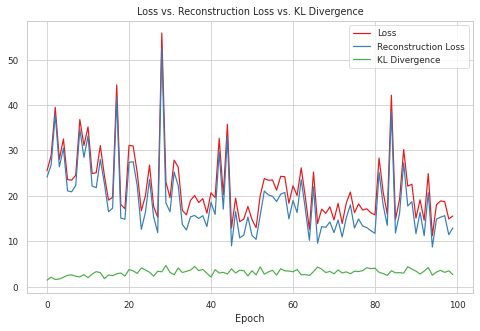

In [36]:
### Loss vs Reconstruction_loss vs KL Divergence
plt.figure(figsize=(8,5))
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['reconstruction_loss'])
plt.plot(train_history.history['kl_loss'])
plt.legend(["Loss", "Reconstruction Loss", "KL Divergence"])
plt.xlabel("Epoch")
plt.title("Loss vs. Reconstruction Loss vs. KL Divergence")

plt.savefig('loss.png')

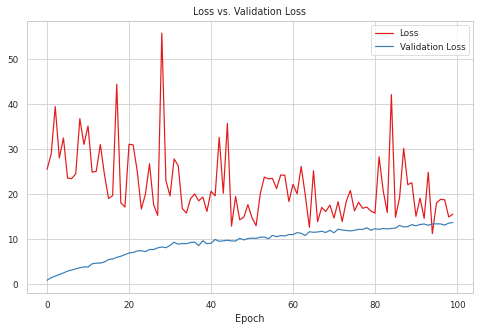

In [37]:
### Train loss vs val loss
# returns the loss value & metrics values for the model in test mode
plt.figure(figsize=(8,5))
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(["Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.title("Loss vs. Validation Loss")

plt.savefig('valLoss.png')

### Latent Space

In [38]:
### PCA (5 dim -> 2 dim): display a 2D plot of the classes in the latent space.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# transform to dataframe
z_test = pd.DataFrame(z_values)
# standardize the data
z_test = StandardScaler().fit_transform(z_test)
# make PCA instance
pca = PCA(n_components=2)

In [39]:
# fit transform features
principalComponents = pca.fit_transform(z_test)

principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])
targetDF = pd.DataFrame(data=testDF_Y.to_numpy(), columns=['target'])
target = testDF_Y.to_numpy()

finalDF = pd.concat([principalDf, targetDF], axis = 1)

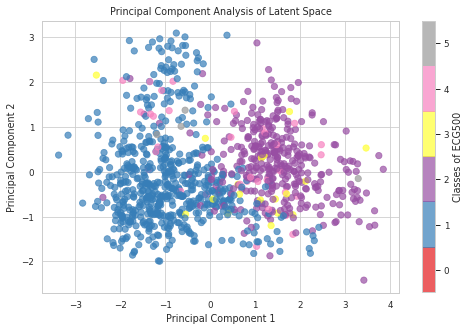

<Figure size 432x288 with 0 Axes>

In [40]:
# scatterplot
plt.figure(figsize=(8,5))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component Analysis of Latent Space')
plt.scatter(finalDF['principal component 1'], finalDF['principal component 2'], c=finalDF['target'], cmap=plt.cm.get_cmap('Set1', 6), s=40, alpha=0.7) # or cmap=hsv
plt.colorbar(ticks=range(6), label='Classes of ECG500')
plt.clim(-0.5, 5.5)

plt.show()
plt.savefig('PCA.png')

# Plot Data Results

---



In [41]:
### Test if Input fits Dim of Output
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of decoded_ecg5000: {}".format(decoded_ecg5000.shape))

### Covert to 2D Array ("-1" = make a dimension (here rows) the size that will use the remaining unspecified elements)
new_x_train= x_train.reshape(-1,140)
new_decoded_ecg5000 = decoded_ecg5000.reshape(-1,140)

print("Shape of Input after reshaping: {}".format(new_x_train.shape))
print("Shape of Output after reshaping: {}".format(new_decoded_ecg5000.shape))

Shape of x_train: (4000, 140, 1)
Shape of decoded_ecg5000: (1000, 140, 1)
Shape of Input after reshaping: (4000, 140)
Shape of Output after reshaping: (1000, 140)


In [42]:
# ### Plot figure for paper
# i = 934 # indize/sample which is going to be plotted
# plt.figure(linewidth = 1, figsize=(25,6))
# plt.xlabel('time steps')
# plt.plot(new_x_train[i])
# plt.show()
# plt.savefig('diagramm_original.jpg')

# plt.figure(linewidth = 1, figsize=(25,6))
# plt.xlabel('time steps')
# plt.plot(new_decoded_ecg5000[i], label='decoded ecg5000')
# plt.show()
# plt.savefig('diagramm_decoded.jpg')

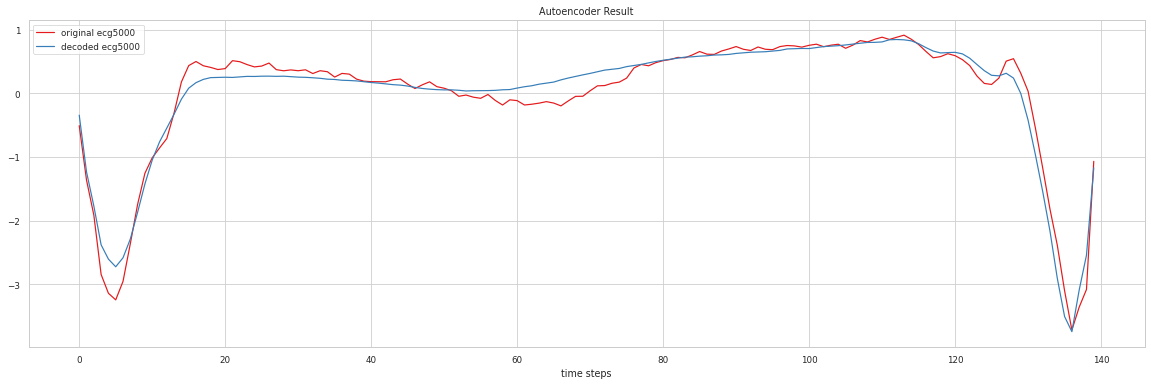

In [43]:
### Plot only one sample
i = 901 # indize/sample which is going to be plotted
plt.figure(linewidth = 1, figsize=(20,6))
plt.title('Autoencoder Result')
plt.xlabel('time steps')
plt.plot(new_x_train[i], label='original ecg5000')
plt.plot(new_decoded_ecg5000[i], label='decoded ecg5000')
plt.legend(loc="upper left")
plt.show()

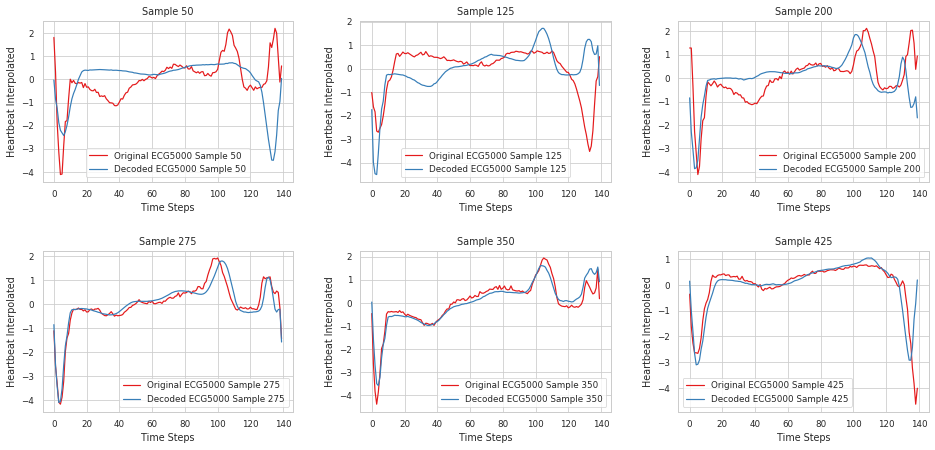

In [44]:
### Plot Multiple Samples
n_rows = 2                   
n_cols = 3

# size properties and layout design for tighter representation
fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(13,6))
fig.tight_layout(w_pad=4, h_pad = 5)

# subplotting
i = 50
for row in range(n_rows):
  for col in range(n_cols):
    axs[row, col].plot(new_x_train[i])
    axs[row, col].plot(new_decoded_ecg5000[i])
    axs[row, col].legend(["Original ECG5000 Sample {}".format(i), "Decoded ECG5000 Sample {}".format(i)])
    axs[row, col].set(xlabel = "Time Steps", ylabel = "Heartbeat Interpolated", title = "Sample {}".format(i))
    i = i + 75

plt.savefig('dataComparison.png')

# Optimization

---

## Hyperparameter (Sckit_GridSearchCV)

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, make_scorer

In [46]:
### Define scorer
def score_mse(y_true, y_pred): # , **kwargs
    """Implementing mean squarred error as a score for RandomizedSearchCV."""

    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    # removing all size 1 dimensions in y_true
    y_true = tf.squeeze(y_true)
    return np.mean(tf.math.squared_difference(y_pred, y_true))

### Define Function for Randomized Search 
def randomizedSearch_pipeline(x_train_data, x_test_data, model, space, n_iter=10, scoring_fit='neg_mean_squared_error', cv=5, do_probabilities = False):
    """Pipeline for RandomizedSearchCV: Select settings and run randomizedSearchCV, returning results."""
    # define randomizedSearch
    rs = RandomizedSearchCV(
        estimator=model,
        param_distributions=space, 
        n_iter=n_iter,
        scoring=scoring_fit,
        n_jobs=1, 
        cv=cv, 
        verbose=2, 
        random_state=1,
    )
    # fit model
    fitted_model = rs.fit(x_train_data, x_train_data, verbose=0)
    # get results
    rs_result = pd.DataFrame(rs.cv_results_)
    # save compromised version of the results
    min_rs_results = pd.concat([pd.DataFrame(rs.cv_results_["mean_test_score"], columns=["score"]),
                                pd.DataFrame(rs.cv_results_["params"])], axis=1)
    min_rs_results = min_rs_results.sort_values(by="score", ascending=False)
    min_rs_results.to_latex(buf='randomizedSearchResults.tex', caption=("Results of 20 candiates using a cross-validation of 5", "Randomized Search Results"), label='table:1')
    
    if do_probabilities:
      pred = fitted_model.predict_proba(x_test_data)
    else:
      pred = fitted_model.predict(x_test_data)
    
    return fitted_model, pred, rs_result, min_rs_results

In [47]:
### Define evaluated params and it's value range
space = {
        #'epochs' :              [50, 100],

        #'latent_activation' :   ['softplus','softmax','sigmoid'],
        #'optimizer' :           ['adam', 'SGD'],
        'batch_size' :          list(range[16,32]),
        'dropout_rate' :        list(np.linspace(0, 1)),
        'regulazier_rate' :     [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
        'learn_rate' :          list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
        }

### Wrap keras custom VAE model with the KerasClassifier thus it implements estimator interface
model = KerasRegressor(build_fn=create_model)

### Run RandomizedSearch
fitted_model, pred, rs_result, min_rs_results= randomizedSearch_pipeline(x_train, x_test, model, space, n_iter=30, scoring_fit=make_scorer(score_mse, greater_is_better=False))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] regulazier_rate=0.001, learn_rate=0.01, dropout_rate=0.3, batch_size=32 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  regulazier_rate=0.001, learn_rate=0.01, dropout_rate=0.3, batch_size=32, total=  10.9s
[CV] regulazier_rate=0.001, learn_rate=0.01, dropout_rate=0.3, batch_size=32 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.9s remaining:    0.0s


[CV]  regulazier_rate=0.001, learn_rate=0.01, dropout_rate=0.3, batch_size=32, total=  11.1s
[CV] regulazier_rate=0.001, learn_rate=0.01, dropout_rate=0.3, batch_size=32 
[CV]  regulazier_rate=0.001, learn_rate=0.01, dropout_rate=0.3, batch_size=32, total=  10.5s
[CV] regulazier_rate=0.001, learn_rate=0.01, dropout_rate=0.3, batch_size=32 
[CV]  regulazier_rate=0.001, learn_rate=0.01, dropout_rate=0.3, batch_size=32, total=  10.9s
[CV] regulazier_rate=0.001, learn_rate=0.01, dropout_rate=0.3, batch_size=32 
[CV]  regulazier_rate=0.001, learn_rate=0.01, dropout_rate=0.3, batch_size=32, total=  10.9s
[CV] regulazier_rate=0.01, learn_rate=0.01, dropout_rate=0.7, batch_size=16 
[CV]  regulazier_rate=0.01, learn_rate=0.01, dropout_rate=0.7, batch_size=16, total=  12.6s
[CV] regulazier_rate=0.01, learn_rate=0.01, dropout_rate=0.7, batch_size=16 
[CV]  regulazier_rate=0.01, learn_rate=0.01, dropout_rate=0.7, batch_size=16, total=  12.7s
[CV] regulazier_rate=0.01, learn_rate=0.01, dropout_rate

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 13.9min finished


In [48]:
### Summarize results
print("----- Results RandomizedSearchCV: -----\n" + "Best: {} using {}\n".format(fitted_model.best_score_, fitted_model.best_params_))
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# pd.reset_option('all')
print("Summary:\n {}".format(rs_result))

----- Results RandomizedSearchCV: -----
Best: -0.2908034145832062 using {'regulazier_rate': 0.01, 'learn_rate': 0.001, 'dropout_rate': 0.2, 'batch_size': 16}

Summary:
     mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0        9.396367      0.168546  ...        0.094990               10
1       11.198662      0.052490  ...        0.095435                8
2        9.403303      0.212426  ...        0.014464                4
3        9.520142      0.188347  ...        0.030076                6
4       11.205231      0.126451  ...        0.018228                1
5       11.059516      0.244842  ...        0.082671               11
6        9.397818      0.344999  ...        0.014488                2
7        8.506161      0.391050  ...        0.017174                7
8        8.637472      0.115294  ...        0.023042                3
9        8.564143      0.206209  ...        0.048579               12
10       8.695802      0.047765  ...        0.008238         

## Dropout

In [49]:
# ###Dropout_rate

# # configure the experiment
# def experiment_dropout():
#   # configure the experiment
#   n_dropout = [0.0, 0.2, 0.4, 0.6, 0.8]
#   # run the experiment
#   results = []
#   for drop_value in n_dropout:
#       # set dropout
#       drop_out_rate = drop_value
#       print("----- Dropout Rate: {} -----".format(drop_out_rate))
#       # evaluate
#       # rather shorten code with defining a train function of code above and using it here
#       vae = VAE(encoder, decoder, name="VAE")
#       vae.compile(optimizer='adam', loss='mean_squared_error')
#       history = vae.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=0)
#       # report performance
#       # rathr make a dataframe or something different which is simpler to plot
#       evaluation = []
#       evaluation.append(vae.evaluate(x_test, y_test))
#       evaluation.append(drop_value)

#       res = []
#       res.append(history.history["val_loss"])
#       print("val_loss = {}".format(res))
#       results.append(evaluation)
#   return results

In [50]:
# results = experiment_dropout()
# # summarize results
# print(results)

# Visualisierung der Hyperparameter Opt. Ergebnisse

Bar Plot


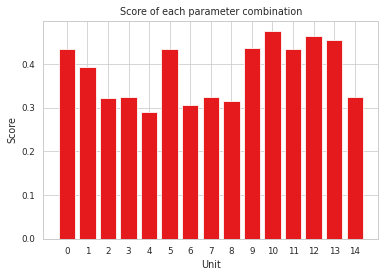

In [51]:
# Scores of our Hyperparameter Optimization
scores = rs_result['mean_test_score'].tolist()

# Positive Score, i.e. each score in scores * (-1)
posScores = []
for s in scores:
  posScores.append(s*(-1))

indices = np.arange(0,len(scores))

plt.bar(indices, posScores, tick_label=indices)
plt.title("Score of each parameter combination")
plt.xlabel("Unit")
plt.ylabel("Score")
# save fig
plt.savefig(fname = "scores.png")

Scatter Plot

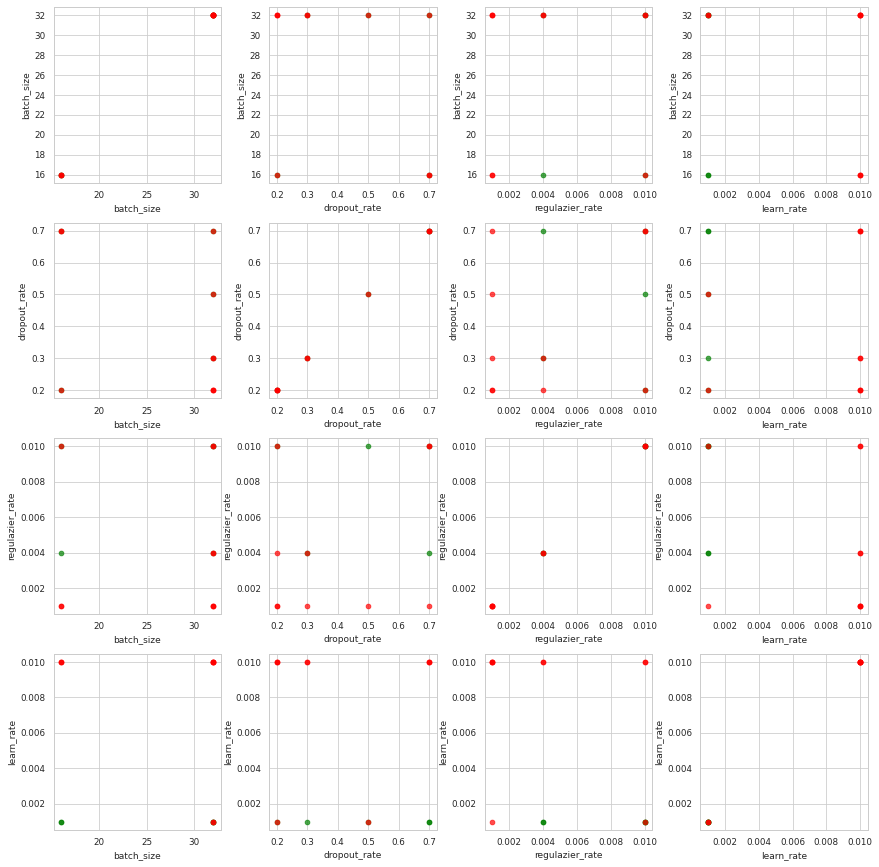

In [53]:
###
features = ['batch_size', 'dropout_rate', 'regulazier_rate', 'learn_rate']
            
fig, axs = plt.subplots(nrows=len(features), ncols=len(features), figsize=(12,12))
fig.tight_layout(w_pad=2, h_pad = 2)
col=0
row=0

for feature_1 in features:
  for feature_2 in features:
    bestComb = min_rs_results.iloc[0:5]
    rest = min_rs_results.iloc[5:]
    axs[row, col].scatter(bestComb[feature_1], bestComb[feature_2], color='green', alpha=0.7)
    axs[row, col].scatter(rest[feature_1], rest[feature_2], color='red', alpha=0.7)
    axs[row, col].set_xlabel(feature_1, fontsize=9)
    axs[row, col].set_ylabel(feature_2,  fontsize=9)
    row=row+1
  col=col+1
  row=0

# save fig
plt.savefig('scoresScatter.png')